# Connect4 dataset viewer

This notebook documents the the dataset in `final_data/`:

- `<dataset>.npz`: dataset generated from dataset MCTS.

Each dataset contains:

- `boards`: 6x7 grid with +1 (to-move), -1 (opponent), 0 (empty)
- `X`: 6x7x2 encoding (channel 0 = to-move, channel 1 = opponent)
- `visits`: raw MCTS visit counts per column (length 7)
- `scores`: raw MCTS net scores per column (length 7)
- `policy`: normalized visits (length 7)
- `q`: per-move expected outcome (length 7)
- `value`: expected outcome for the board (length 1)

We will load the files, inspect shapes, show full examples with visual boards,
show how to mirror a dataset, and describe how to train and run a two-headed
policy/value CNN.


## Data sources (tunables)

Update these paths/URLs when your data moves (local file paths or GitHub release links).


In [14]:
from pathlib import Path
import urllib.request
import tempfile

# Data source can be a local path OR a direct URL to a .npz file.
DATASET_NPZ = "https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/vanilla_mcts_not_mirrored_200_3000.npz"


def load_npz(source):
    # Load from local path or download URL to a temp file.
    if str(source).startswith("http://") or str(source).startswith("https://"):
        tmp_dir = Path(tempfile.gettempdir())
        tmp_path = tmp_dir / Path(str(source)).name
        if not tmp_path.exists():
            urllib.request.urlretrieve(str(source), tmp_path)
        return np.load(tmp_path)
    return np.load(Path(source))


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset using the tunable above.
npz = {
    "data": load_npz(DATASET_NPZ),
}
print("Loaded dataset:", DATASET_NPZ)


Loaded dataset: https://github.com/AHMerrill/connect-4/releases/download/v0.1-data/vanilla_mcts_not_mirrored_200_3000.npz


## Load the dataset

This block loads the two `.npz` files and stores them in a dictionary so we can
reference them consistently. We keep the paths explicit to avoid accidental
mixups.


## Quick dataset summary

This block prints the number of boards and the shapes of each stored array. It is
useful for confirming that all required fields are present and consistent.


In [16]:
data = npz["data"]
print("Dataset: data")
print("boards:", data["boards"].shape)
print("X:", data["X"].shape)
print("visits:", data["visits"].shape)
print("scores:", data["scores"].shape)
print("policy:", data["policy"].shape)
print("q:", data["q"].shape)
print("value:", data["value"].shape)


Dataset: data
boards: (610112, 6, 7)
X: (610112, 6, 7, 2)
visits: (610112, 7)
scores: (610112, 7)
policy: (610112, 7)
q: (610112, 7)
value: (610112, 1)


## Visualize a board

We render the 6x7 board so it is easy to see where the current player (+1) and
opponent (-1) pieces are. This is purely a visualization helper; it does not
change any data.


In [17]:
def plot_board(board, title=None):
    # Map: -1 (opponent) -> red, 0 -> white, +1 (to-move) -> blue.
    cmap = plt.cm.get_cmap("bwr", 3)
    plt.figure(figsize=(4, 3))
    plt.imshow(board, cmap=cmap, vmin=-1, vmax=1)
    plt.xticks(range(7))
    plt.yticks(range(6))
    plt.grid(True, color="black", linewidth=0.5)
    if title:
        plt.title(title)
    plt.show()


## Full random examples (three from each dataset)

This block prints **everything** for three random rows from each dataset:

- `board` (raw 6x7)
- `X` shape and channel sums
- `visits`, `scores`, `policy`, `q`, `value`
- A visual board plot

This is a sanity check that the data is internally consistent.


=== Random samples from data ===
Sample 1 (index 576497)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0]
 [ 0  0  0  0  0 -1  0]
 [ 0  1  0  1  0  1  0]
 [ 0 -1  0 -1  0  1  1]
 [-1 -1 -1  1  1  1 -1]]
X shape: (6, 7, 2)
X channel0 sum: 8.0 channel1 sum: 8.0
visits: [48. 19. 49. 15. 19. 17. 33.]
scores: [ 6. -7.  3. -7. -7. -7. -3.]
policy: [0.24  0.095 0.245 0.075 0.095 0.085 0.165]
q: [ 0.125      -0.36842105  0.06122449 -0.46666667 -0.36842105 -0.4117647
 -0.09090909]
value: [-0.11]


/tmp/ipython-input-490388798.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("bwr", 3)


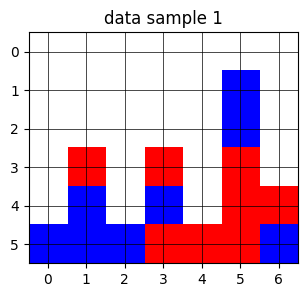

Sample 2 (index 381378)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0 -1  0 -1  1  0  0]
 [ 1 -1  1  1 -1  0  0]
 [-1  1 -1 -1 -1  1  0]
 [-1 -1  1  1 -1  1  0]]
X shape: (6, 7, 2)
X channel0 sum: 10.0 channel1 sum: 11.0
visits: [37. 15. 24. 49. 12. 51. 12.]
scores: [ 3. -5. -2.  9. -6. 15. -6.]
policy: [0.185 0.075 0.12  0.245 0.06  0.255 0.06 ]
q: [ 0.08108108 -0.33333334 -0.08333334  0.18367347 -0.5         0.29411766
 -0.5       ]
value: [0.04]


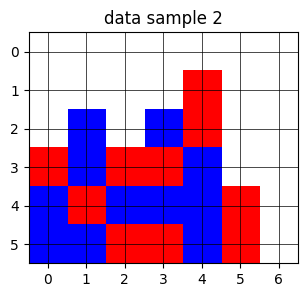

Sample 3 (index 417426)
board: [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0]
 [ 0  0  1 -1 -1  0  0]
 [ 0  1 -1 -1 -1  1 -1]]
X shape: (6, 7, 2)
X channel0 sum: 5.0 channel1 sum: 6.0
visits: [24. 14. 57. 24. 27. 35. 19.]
scores: [ 8.  0. 37.  8. 10. 17.  5.]
policy: [0.12  0.07  0.285 0.12  0.135 0.175 0.095]
q: [0.33333334 0.         0.64912283 0.33333334 0.37037036 0.4857143
 0.2631579 ]
value: [0.425]


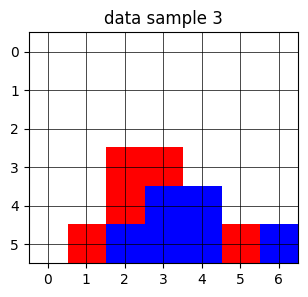

In [18]:
rng = np.random.default_rng(7)

data = npz["data"]
print("=== Random samples from data ===")
n = data["boards"].shape[0]
for i in range(3):
    idx = int(rng.integers(0, n))
    board = data["boards"][idx]
    X = data["X"][idx]
    visits = data["visits"][idx]
    scores = data["scores"][idx]
    policy = data["policy"][idx]
    q = data["q"][idx]
    value = data["value"][idx]

    print(f"Sample {i+1} (index {idx})")
    print("board:", board)
    print("X shape:", X.shape)
    print("X channel0 sum:", float(X[:, :, 0].sum()), "channel1 sum:", float(X[:, :, 1].sum()))
    print("visits:", visits)
    print("scores:", scores)
    print("policy:", policy)
    print("q:", q)
    print("value:", value)

    plot_board(board, title=f"data sample {i+1}")


## Mirror a dataset (for symmetry augmentation)

This block shows how to mirror boards left-to-right and merge duplicates.

- Boards are mirrored by flipping columns.
- Policy, visits, and scores are mirrored by reversing the 7-column vectors.
- When a mirrored board already exists, we **merge** by summing visits/scores
  and averaging policy/value.

This produces a symmetry-augmented dataset without changing the meaning of the
labels.


In [19]:
def mirror_dataset(data):
    boards = data["boards"]
    X = data["X"]
    policy = data["policy"]
    visits = data["visits"]
    scores = data["scores"]
    value = data["value"]

    merged = {}

    def add_entry(b, x, p, v, sc, val):
        key = tuple(b.ravel())
        if key not in merged:
            merged[key] = {
                "board": b,
                "X": x,
                "policy_sum": p.copy(),
                "visits_sum": v.copy(),
                "scores_sum": sc.copy(),
                "value_sum": val.copy(),
                "count": 1,
            }
            return
        merged[key]["policy_sum"] += p
        merged[key]["visits_sum"] += v
        merged[key]["scores_sum"] += sc
        merged[key]["value_sum"] += val
        merged[key]["count"] += 1

    for i in range(boards.shape[0]):
        b = boards[i]
        add_entry(b, X[i], policy[i], visits[i], scores[i], value[i])

        b_m = b[:, ::-1]
        x_m = X[i][:, ::-1, :]
        p_m = policy[i][::-1]
        v_m = visits[i][::-1]
        s_m = scores[i][::-1]
        add_entry(b_m, x_m, p_m, v_m, s_m, value[i])

    new_X = np.stack([v["X"] for v in merged.values()], axis=0)
    new_policy = np.stack([v["policy_sum"] / v["count"] for v in merged.values()], axis=0)
    new_visits = np.stack([v["visits_sum"] for v in merged.values()], axis=0)
    new_scores = np.stack([v["scores_sum"] for v in merged.values()], axis=0)
    new_value = np.stack([v["value_sum"] / v["count"] for v in merged.values()], axis=0)

    print("Original boards:", boards.shape[0])
    print("Mirrored/merged boards:", new_X.shape[0])
    return {
        "X": new_X,
        "policy": new_policy,
        "visits": new_visits,
        "scores": new_scores,
        "value": new_value,
    }

# Example: mirror the vanilla dataset in memory.
mirrored_vanilla = mirror_dataset(npz["data"])


Original boards: 610112
Mirrored/merged boards: 1127458


## Training a two-headed CNN (policy + value)

Below is a minimal training skeleton for a two-headed model:

- The policy head predicts the move distribution (softmax, 7 outputs).
- The value head predicts the expected outcome (tanh, 1 output).

In practice, you should also use train/validation splits, learning rate schedules,
regularization, and early stopping. This example is a compact reference, not a
full training pipeline.


In [20]:
import tensorflow as tf

# Use the mirrored dataset for training.
data = mirrored_vanilla
X = data["X"].astype(np.float32)
policy = data["policy"].astype(np.float32)
value = data["value"].astype(np.float32)

# Simple train/validation split.
rng = np.random.default_rng(7)
idx = rng.permutation(X.shape[0])
split = int(0.8 * X.shape[0])
train_idx, test_idx = idx[:split], idx[split:]

X_train, X_test = X[train_idx], X[test_idx]
policy_train, policy_test = policy[train_idx], policy[test_idx]
value_train, value_test = value[train_idx], value[test_idx]

inputs = tf.keras.Input(shape=(6, 7, 2), name="board_input")
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.Flatten()(x)

p = tf.keras.layers.Dense(64, activation="relu")(x)
policy_out = tf.keras.layers.Dense(7, activation="softmax", name="policy_output")(p)

v = tf.keras.layers.Dense(64, activation="relu")(x)
value_out = tf.keras.layers.Dense(1, activation="tanh", name="value_output")(v)

model = tf.keras.Model(inputs=inputs, outputs=[policy_out, value_out])
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss={"policy_output": "categorical_crossentropy", "value_output": "mse"},
    metrics={"policy_output": ["accuracy"], "value_output": ["mse"]},
)

model.fit(
    X_train,
    {"policy_output": policy_train, "value_output": value_train},
    validation_data=(X_test, {"policy_output": policy_test, "value_output": value_test}),
    epochs=10,
    batch_size=256,
)


Epoch 1/10
3524/3524 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 1.7938 - policy_output_accuracy: 0.4803 - policy_output_loss: 1.7299 - value_output_loss: 0.0638 - value_output_mse: 0.0638 - val_loss: 1.6411 - val_policy_output_accuracy: 0.5935 - val_policy_output_loss: 1.6244 - val_value_output_loss: 0.0168 - val_value_output_mse: 0.0168
Epoch 2/10
3524/3524 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.6363 - policy_output_accuracy: 0.6003 - policy_output_loss: 1.6211 - value_output_loss: 0.0152 - value_output_mse: 0.0152 - val_loss: 1.6279 - val_policy_output_accuracy: 0.6143 - val_policy_output_loss: 1.6154 - val_value_output_loss: 0.0125 - val_value_output_mse: 0.0125
Epoch 3/10
3524/3524 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.6238 - policy_output_accuracy: 0.6172 - policy_output_loss: 1.6122 - value_output_loss: 0.0117 - value_output_mse: 0.0117 - val_loss: 1.6247 - val_policy_output_accuracy: 0.6196 - val_policy_output_loss: 1.6127 - val_value_output_loss: 0.0120 - val_value_ou

## Inference example (policy + value)

This block shows how to use a trained model for inference on a single board:

- Build a board in +1/-1/0 format.
- Encode it into 6x7x2.
- Run the model to get policy and value.
- Mask illegal moves and pick the best column.

This is the basic building block for dataset MCTS.


Note: Actual inference could include an MCTS step or a "check for win" / "check for loss" and not just pure CNN inference


In [21]:
# Example board (replace with an actual position).
board = np.zeros((6, 7), dtype=np.int8)
board[5, 3] = 1
board[5, 2] = -1

# Encode and run inference.
x = np.stack([(board == 1).astype(np.float32), (board == -1).astype(np.float32)], axis=-1)
policy_pred, value_pred = model.predict(x[None, ...], verbose=0)
policy = policy_pred[0]
value = float(value_pred[0][0])

# Mask illegal moves.
legal = [i for i in range(7) if abs(board[0, i]) < 0.1]
masked = np.full_like(policy, -1e9)
masked[legal] = policy[legal]
move = int(np.argmax(masked))

print("Predicted policy:", policy)
print("Predicted value:", value)
print("Chosen move:", move)


Predicted policy: [0.09362558 0.07517472 0.20623136 0.31835958 0.1130689  0.1113978
 0.08214208]
Predicted value: 0.26174196600914
Chosen move: 3


## Lightweight game simulator for quick win-rate checks

The next blocks run short matchups to sanity-check the inference model against
various opponents. This is not a full tournament; it is a quick signal.

Important assumptions:
- `model` is already defined above (from the training example or a loaded model).
- MCTS here is the same simple rollout-based version used earlier in this project.

We alternate who goes first so results are not biased by move order.


In [22]:
import random

# Simple Connect4 helpers (minimal set for quick evaluation).
def update_board(board_temp, color, column):
    board = board_temp.copy()
    nrow = board.shape[0]
    colsum = np.abs(board[:, column]).sum()
    row = int(nrow - 1 - colsum)
    if row > -0.5:
        board[row, column] = 1 if color == "plus" else -1
    return board


def check_for_win(board, col):
    nrow, ncol = board.shape
    colsum = np.abs(board[:, col]).sum()
    row = int(nrow - colsum)
    # vertical
    if row + 3 < nrow:
        vert = board[row, col] + board[row+1, col] + board[row+2, col] + board[row+3, col]
        if vert == 4:
            return "v-plus"
        elif vert == -4:
            return "v-minus"
    # horizontal
    if col + 3 < ncol:
        hor = board[row, col] + board[row, col+1] + board[row, col+2] + board[row, col+3]
        if hor == 4:
            return "h-plus"
        elif hor == -4:
            return "h-minus"
    if col - 1 >= 0 and col + 2 < ncol:
        hor = board[row, col-1] + board[row, col] + board[row, col+1] + board[row, col+2]
        if hor == 4:
            return "h-plus"
        elif hor == -4:
            return "h-minus"
    if col - 2 >= 0 and col + 1 < ncol:
        hor = board[row, col-2] + board[row, col-1] + board[row, col] + board[row, col+1]
        if hor == 4:
            return "h-plus"
        elif hor == -4:
            return "h-minus"
    if col - 3 >= 0:
        hor = board[row, col-3] + board[row, col-2] + board[row, col-1] + board[row, col]
        if hor == 4:
            return "h-plus"
        elif hor == -4:
            return "h-minus"
    # diag down-right
    if row < 3 and col < 4:
        dr = board[row, col] + board[row+1, col+1] + board[row+2, col+2] + board[row+3, col+3]
        if dr == 4:
            return "d-plus"
        elif dr == -4:
            return "d-minus"
    if row - 1 >= 0 and col - 1 >= 0 and row + 2 < 6 and col + 2 < 7:
        dr = board[row-1, col-1] + board[row, col] + board[row+1, col+1] + board[row+2, col+2]
        if dr == 4:
            return "d-plus"
        elif dr == -4:
            return "d-minus"
    if row - 2 >= 0 and col - 2 >= 0 and row + 1 < 6 and col + 1 < 7:
        dr = board[row-2, col-2] + board[row-1, col-1] + board[row, col] + board[row+1, col+1]
        if dr == 4:
            return "d-plus"
        elif dr == -4:
            return "d-minus"
    if row - 3 >= 0 and col - 3 >= 0:
        dr = board[row-3, col-3] + board[row-2, col-2] + board[row-1, col-1] + board[row, col]
        if dr == 4:
            return "d-plus"
        elif dr == -4:
            return "d-minus"
    # diag down-left
    if row + 3 < 6 and col - 3 >= 0:
        dl = board[row, col] + board[row+1, col-1] + board[row+2, col-2] + board[row+3, col-3]
        if dl == 4:
            return "d-plus"
        elif dl == -4:
            return "d-minus"
    if row - 1 >= 0 and col + 1 < 7 and row + 2 < 6 and col - 2 >= 0:
        dl = board[row-1, col+1] + board[row, col] + board[row+1, col-1] + board[row+2, col-2]
        if dl == 4:
            return "d-plus"
        elif dl == -4:
            return "d-minus"
    if row - 2 >= 0 and col + 2 < 7 and row + 1 < 6 and col - 1 >= 0:
        dl = board[row-2, col+2] + board[row-1, col+1] + board[row, col] + board[row+1, col-1]
        if dl == 4:
            return "d-plus"
        elif dl == -4:
            return "d-minus"
    if row - 3 >= 0 and col + 3 < 7:
        dl = board[row-3, col+3] + board[row-2, col+2] + board[row-1, col+1] + board[row, col]
        if dl == 4:
            return "d-plus"
        elif dl == -4:
            return "d-minus"
    return "nobody"


def find_legal(board):
    return [i for i in range(7) if abs(board[0, i]) < 0.1]


def rollout(board, next_player):
    winner = "nobody"
    player = next_player
    while winner == "nobody":
        legal = find_legal(board)
        if len(legal) == 0:
            return "tie"
        move = random.choice(legal)
        board = update_board(board, player, move)
        winner = check_for_win(board, move)
        player = "minus" if player == "plus" else "plus"
    return winner


def mcts_policy_value(board_temp, color0, nsteps):
    board = board_temp.copy()
    legal = find_legal(board)

    # Forced win: return a one-hot policy and +1 score for that move.
    for m in legal:
        bt = update_board(board, color0, m)
        wi = check_for_win(bt, m)
        if wi[2:] == color0:
            visits = np.zeros(7, dtype=np.float32)
            scores = np.zeros(7, dtype=np.float32)
            visits[m] = 1.0
            scores[m] = 1.0
            return visits, scores

    mcts_dict = {tuple(board.ravel()): [0, 0]}
    for _ in range(nsteps):
        color = color0
        winner = "nobody"
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        while winner == "nobody":
            legal_loop = find_legal(board_mcts)
            if len(legal_loop) == 0:
                winner = "tie"
                break
            board_list = [tuple(update_board(board_mcts, color, col).ravel()) for col in legal_loop]
            for bl in board_list:
                if bl not in mcts_dict:
                    mcts_dict[bl] = [0, 0]
            ucb1 = np.zeros(len(legal_loop))
            for i in range(len(legal_loop)):
                num_denom = mcts_dict[board_list[i]]
                if num_denom[0] == 0:
                    ucb1[i] = 10 * nsteps
                else:
                    ucb1[i] = num_denom[1] / num_denom[0] + 2 * np.sqrt(np.log(mcts_dict[path[-1]][0]) / mcts_dict[board_list[i]][0])
            chosen = int(np.argmax(ucb1))
            board_mcts = update_board(board_mcts, color, legal_loop[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts, legal_loop[chosen])
            if winner != "nobody":
                break
            color = "minus" if color == "plus" else "plus"
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = rollout(board_mcts, color)
                break

        # Backpropagate
        for i, board_state in enumerate(path):
            mcts_dict[board_state][0] += 1
            if winner == "tie":
                continue
            if winner[2] == color0[0]:
                if i % 2 == 1:
                    mcts_dict[board_state][1] += 1
                else:
                    mcts_dict[board_state][1] -= 1
            else:
                if i % 2 == 1:
                    mcts_dict[board_state][1] -= 1
                else:
                    mcts_dict[board_state][1] += 1

    visits = np.zeros(7, dtype=np.float32)
    scores = np.zeros(7, dtype=np.float32)
    for col in legal:
        child = tuple(update_board(board, color0, col).ravel())
        v, s = mcts_dict.get(child, [0, 0])
        visits[col] = float(v)
        scores[col] = float(s)
    return visits, scores


def encode_two_channel(board_6x7):
    plus = (board_6x7 == 1).astype(np.float32)
    minus = (board_6x7 == -1).astype(np.float32)
    return np.stack([plus, minus], axis=-1)


def model_move(board, player):
    if "model" not in globals():
        raise RuntimeError("Define or load `model` before running matchups.")
    board_plus = board if player == "plus" else -board
    x = encode_two_channel(board_plus)[None, ...]
    policy_pred, _ = model.predict(x, verbose=0)
    policy = policy_pred[0]
    legal = find_legal(board)
    if len(legal) == 0:
        return None
    masked = np.full_like(policy, -1e9)
    masked[legal] = policy[legal]
    return int(np.argmax(masked))


def mcts_move(board, player, nsteps):
    visits, _ = mcts_policy_value(board if player == "plus" else -board, "plus", nsteps)
    legal = find_legal(board)
    if len(legal) == 0:
        return None
    masked = np.full_like(visits, -1e9, dtype=np.float32)
    masked[legal] = visits[legal]
    return int(np.argmax(masked))


def play_game(agent, opponent, random_opening_moves=0):
    board = np.zeros((6, 7), dtype=np.int8)
    player = "plus"

    # Optional random opening phase.
    for _ in range(random_opening_moves * 2):
        legal = find_legal(board)
        if len(legal) == 0:
            return "tie"
        move = random.choice(legal)
        board = update_board(board, player, move)
        result = check_for_win(board, move)
        if result != "nobody":
            return result[2:]
        player = "minus" if player == "plus" else "plus"

    while True:
        legal = find_legal(board)
        if len(legal) == 0:
            return "tie"

        if player == "plus":
            move = agent(board, player)
        else:
            move = opponent(board, player)

        if move is None:
            return "tie"

        board = update_board(board, player, move)
        result = check_for_win(board, move)
        if result != "nobody":
            return result[2:]

        player = "minus" if player == "plus" else "plus"


def evaluate_opponent(opponent_fn, games=20, random_opening_moves=0):
    results = {"win": 0, "loss": 0, "tie": 0}
    half = games // 2

    # Our model as plus.
    for _ in range(half):
        winner = play_game(model_move, opponent_fn, random_opening_moves=random_opening_moves)
        if winner == "plus":
            results["win"] += 1
        elif winner == "minus":
            results["loss"] += 1
        else:
            results["tie"] += 1

    # Our model as minus (swap roles).
    for _ in range(games - half):
        winner = play_game(opponent_fn, model_move, random_opening_moves=random_opening_moves)
        if winner == "minus":
            results["win"] += 1
        elif winner == "plus":
            results["loss"] += 1
        else:
            results["tie"] += 1

    total = games
    print("Wins:", results["win"], "Losses:", results["loss"], "Ties:", results["tie"])
    print("Win rate:", results["win"] / total)
    print("Tie rate:", results["tie"] / total)


## Opponent 1: fully random

This baseline opponent chooses a legal move uniformly at random. The win rate here
is a quick sanity check that the model is doing something sensible.


In [23]:
def random_opponent(board, player):
    legal = find_legal(board)
    if len(legal) == 0:
        return None
    return int(random.choice(legal))

print("Random opponent (20 games):")
evaluate_opponent(random_opponent, games=20, random_opening_moves=0)


Random opponent (20 games):
Wins: 20 Losses: 0 Ties: 0
Win rate: 1.0
Tie rate: 0.0


## Opponent 2: random 5 moves, then MCTS (nsteps=200)

This opponent plays randomly for the first 5 moves to create diverse openings,
then switches to MCTS with 200 rollouts for the rest of the game.


In [24]:
def mcts_200_opponent(board, player):
    return mcts_move(board, player, nsteps=200)

print("Random 5 moves, then MCTS-200 (20 games):")
evaluate_opponent(mcts_200_opponent, games=20, random_opening_moves=5)


Random 5 moves, then MCTS-200 (20 games):
Wins: 11 Losses: 9 Ties: 0
Win rate: 0.55
Tie rate: 0.0


## Opponent 3: random 5 moves, then MCTS (nsteps=800)

Same as above, but with a stronger MCTS search after the opening randomness.


In [25]:
def mcts_800_opponent(board, player):
    return mcts_move(board, player, nsteps=800)

print("Random 5 moves, then MCTS-800 (20 games):")
evaluate_opponent(mcts_800_opponent, games=20, random_opening_moves=5)


Random 5 moves, then MCTS-800 (20 games):
Wins: 11 Losses: 9 Ties: 0
Win rate: 0.55
Tie rate: 0.0


## Opponent 4: MCTS from move 1 (nsteps=500)

This opponent uses MCTS from the very first move, with a mid-strength rollout
budget.


In [26]:
def mcts_500_opponent(board, player):
    return mcts_move(board, player, nsteps=500)

print("MCTS-500 from move 1 (20 games):")
evaluate_opponent(mcts_500_opponent, games=20, random_opening_moves=0)


MCTS-500 from move 1 (20 games):
Wins: 8 Losses: 12 Ties: 0
Win rate: 0.4
Tie rate: 0.0


## Opponent 5: MCTS from move 1 (nsteps=1000)

This opponent uses a stronger MCTS search for every move.


In [27]:
def mcts_1000_opponent(board, player):
    return mcts_move(board, player, nsteps=1000)

print("MCTS-1000 from move 1 (20 games):")
evaluate_opponent(mcts_1000_opponent, games=20, random_opening_moves=0)


MCTS-1000 from move 1 (20 games):
Wins: 6 Losses: 14 Ties: 0
Win rate: 0.3
Tie rate: 0.0
